In [112]:
#authored by arjun aditham on 08-Feb-2024; this is a crude attempt to navigate datasets and recolor the pre-fusion rabies trimer
#by functional effect scores. 

In [113]:
#This is a crude attempt to rewrite the b-factors with mean functional effect data for rabies glycoprotein trimer. 

import subprocess
import sys

import pandas as pd 
import polyclonal
import numpy as np

In [114]:
#settings for PDB file

input_pdb_file = 'data/6lgw.pdb'
target_chains = ['E','F'];


functional_effects_file = 'results/func_effects/averages/HEK293T_entry_func_effects.csv';

output_pdb_file_name = 'results/6lgw_functional_effects.pdb'

#output_file_sub_name = '/results/func_effects/averages/HEK293T_entry_func_effects.csv';

In [115]:
colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs)

In [116]:
#make subset dataframe that only contains chains of interest--A,B,C (trimer only)
pdb_subsetchains = pdb[pdb['chainid'].isin(target_chains)]

In [117]:
#get functional effect data
functional_effects_data = pd.read_csv(functional_effects_file)

#filter by times seen (n>3)
functional_effects_data_filter = functional_effects_data[functional_effects_data['times_seen']>3]

#group by site # to take mean of effect. I'm not going to worry about effect_std rn 
#because the error propagation is going over my head (also idk if that is projected)
functional_effects_data_grouped = functional_effects_data_filter.groupby('site')


#take mean at every position
def get_mean(df):
    result = df.copy();
    functional_effect_values = result['effect'];

    result['mean_func_effect']= np.mean(functional_effect_values);

    return result.reset_index(drop=True);


functional_effects_data_grouped= functional_effects_data_grouped.apply(get_mean)


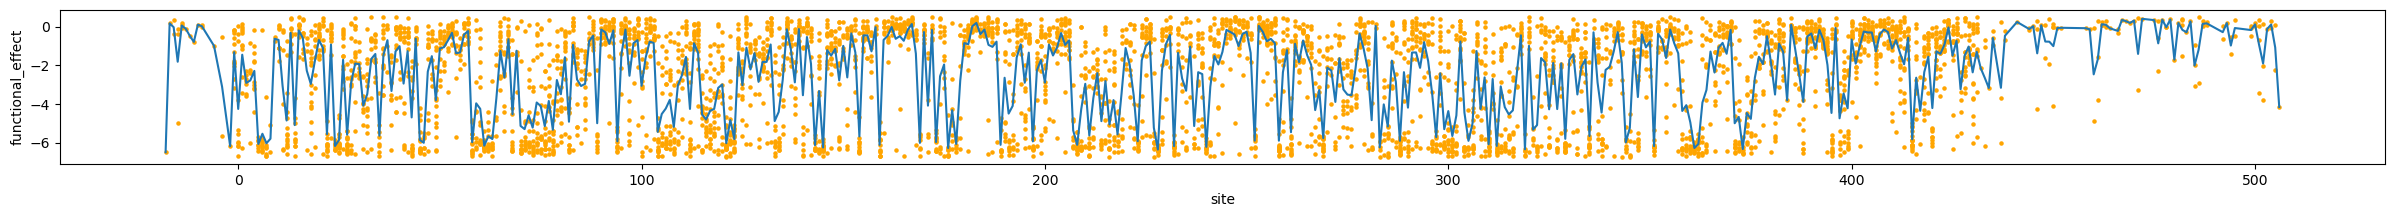

In [118]:
functional_effects_data_grouped

#let me make a crude plot just to see if things make sense.

import seaborn as sb
from matplotlib import pyplot as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

fig,ax= pl.subplots(figsize=(30,2))
pl.plot(functional_effects_data_grouped['site'],functional_effects_data_grouped['mean_func_effect'])
pl.scatter(functional_effects_data_grouped['site'],functional_effects_data_grouped['effect'],s=5,c='orange')

pl.ylabel('functional_effect')
pl.xlabel('site')

pl.show()


#okay these seem to indicate that these values are position by position means (best I can tell).

In [119]:
#I only need 1 mean value per site. So i will just drop duplicates accordingly. 

functional_effects_data_grouped = functional_effects_data_grouped.drop_duplicates(['site']);

In [120]:
df = pd.DataFrame(columns=['chain','site','mean'])


In [121]:
chain_array=list();
site_array=list();
mean_array=list();

site_list = functional_effects_data_grouped['site'].tolist();
means_list = functional_effects_data_grouped['mean_func_effect'].tolist();

for i in target_chains:
    for j in range(0, len(site_list)):
        chain_array.append(i);
        site_array.append(site_list[j]);
        mean_array.append(means_list[j]);
    
        

In [122]:
#okay let's jsut make the df have values now
df['chain']=chain_array;
df['site']=site_array;
df['mean']=mean_array

df

#specific formatting for df
#df = df[~df['site'].str.contains("a|b|c|d|e|f|g")]
df['site'] = df['site'].astype(int)
df=df[df['site']>0];

In [123]:
# save the new PDB file
polyclonal.pdb_utils.reassign_b_factor(input_pdbfile=input_pdb_file, 
                                        output_pdbfile=output_pdb_file_name, 
                                        df=df, 
                                        metric_col='mean')

In [124]:
df

,chain,site,mean
15,E,1,-1.453589
16,E,2,-2.909429
17,E,3,-2.780440
18,E,4,-2.288770
19,E,5,-6.066714
...,...,...,...
999,F,502,-1.905767
1000,F,503,-0.120600
1001,F,504,0.108575
1002,F,505,-1.079085
